In [41]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.stats import expon
from scipy.stats import uniform
from scipy.optimize import minimize_scalar
from scipy.optimize import basinhopping

In [6]:
def utility(ki,gammai,kj,Vj,t):
    """
    Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place

    Arguments:
        ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
        gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
        kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
        Vj: J x 1 vector of doctors' "service quality", V_j parameter.
        t: parametrized cost of visit.
    """

    # Reshaping parameters to ensure proper broadcasting
    ki = np.array(ki).reshape((1,-1))             # 1 x I
    gammai = np.array(gammai).reshape((1,-1))     # 1 x I
    kj = np.array(kj).reshape((-1,1))             # J x 1
    Vj = np.array(Vj).reshape((-1,1))             # J x 1

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
                    # This way γ_i is summed if patient i's κ_i is above doctor j's threshold κ_j.

In [7]:
class LogitSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    λ):     # Scalar. Logit shape parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.λ = ki, gammai, kj, Vj, t, λ

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def alpha_matrix(self):
        """
        Intermediate matrix used to compute S matrix of patients' sij's.
        alpha_ij equals e^(λ*uij) if uij > 0, else 0 (free disposal requirement)
        """

        λ = self.λ  # scalar
        U = self.U()  # J x I matrix of uij's

        return np.where(U > 0, np.exp(λ*U), 0)
    
    def S(self):
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  alpha_ij / Σ_j=1^J (alpha_ij)       if      Σ_j=1^J (alpha_ij) > 0
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # alpha_matrix is a J x I matrix where alpha_ij equals e^(λ*uij) if uij > 0, else 0
        alpha_matrix = self.alpha_matrix()
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning      
            return np.where(alphai_total != 0, alpha_matrix/alphai_total, 0)

In [8]:
class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        λ,  # Logit parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij): # Search function
       
        self.I, self.F, self.G, self.t, self.λ = I, F, G, t, λ      # Save parameters
        self.R, self.P, self.V, self.sij = R, P, V, sij         

    
    def S(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, λ, V, sij = self.I, self.F, self.G, self.t, self.λ, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V
        kj = k0

        return sij(ki,gammai,kj,Vj,t,λ).S()

    def Q(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)

        return np.sum(S, axis = 1)
    
    def X(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def utility(self, k0, R, P, s=123):

        Q = self.Q(k0, s)
        X = self.X(k0, s)

        return R(Q) - P(X)

    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)
        dQ = self.dQ(k0)         # Jacobians of Q and J
        dX = self.dX(k0)
        dQ_gradient = np.diagonal(dQ)   # For the FOC we just use the gradient
        dX_gradient = np.diagonal(dX)

        return dR(Q)*dQ_gradient - dP(X)*dX_gradient
    
    def simple_FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Q(k0, s)
        X = self.X(k0, s)

        return (dR(Q) - dP(X))

In [9]:
# Number of doctors and patients
I = 10000
J = 50

b = 5
F = uniform(scale = 1)
G = uniform(scale = 1)
H = uniform(scale = 10)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H
V = np.sort(V)

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

d2R = lambda x: 0 + x - x
d2P = lambda x: p + x - x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 1

In [10]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, LogitSearch)

In [55]:
### def graph_component_i(f, k_original, i_values, start, stop, num_points=100)    

### # Check if k_original has enough elements for the highest index in i_values
### if len(k_original) < max(i_values) + 1:
###    raise ValueError("Input vector must be large enough to accommodate all indices in i_values.")


num = 11
custom_function = lambda x: LogitModel.utility(x, R, P)
k0 = np.ones(J)*0.5

# Generate a linspace for the components
linspace_values = np.linspace(min, max, num)

# Keep the original vector unchanged for components not in i_values
k_fixed = np.copy(k0)

k_output = []
# Plot results for each index in i_values
for i in range(len(k0)):
    # Store the results of the function evaluations for this component
    results_1d = []
    
    # Evaluate the function over the linspace
    for value in linspace_values:
        k_fixed[i] = value  # Update the i-th component
        result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
        results_1d.append(result)

    max_index = np.argmax(results_1d)

    new_k = linspace_values[max_index]
    step = 0.05

    if (new_k == 0 or new_k == 1):
        k_output.append(new_k)
    else:
        decimals = np.linspace(new_k - step, new_k + step, num)

        results_2d = []
        # Evaluate the function over the linspace
        for value in decimals:
            k_fixed[i] = value  # Update the i-th component
            result = custom_function(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
            results_2d.append(result)

        max_index_2 = np.argmax(results_2d)
        result_k = decimals[max_index_2]
        k_output.append(result_k)

np.array(k_output)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.07, 0.08,
       0.08, 0.08, 0.09, 0.09, 0.09, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.11, 0.11, 0.11, 0.11, 0.11, 0.37, 0.37, 0.4 , 0.49,
       0.49, 0.52, 0.55, 0.56, 0.65, 0.68, 0.74, 0.74, 0.74, 0.75, 0.77,
       0.91, 0.92, 0.94, 1.  , 1.  , 1.  ])

In [51]:
np.array(k_output)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.06, 0.06,
       0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
       0.06, 0.06, 0.06, 0.06, 0.28, 0.28, 0.39, 0.39, 0.39, 0.39, 0.5 ,
       0.5 , 0.5 , 0.61, 0.61, 0.72, 0.72, 0.72, 0.83, 0.83, 0.83, 0.83,
       0.94, 0.94, 0.94, 1.  , 1.  , 1.  ])

In [38]:
k0 = np.ones(J)*0.5

def fi(x, k0, i):
    k_fixed = np.copy(k0)
    k_fixed[i] = x 

    return LogitModel.utility(x, R, P)



k_output = []
# Plot results for each index in i_values
for i in range(len(k0)):
    lambda_fi = lambda x: fi(x, k0, i)[i]
    k_response = minimize_scalar(lambda_fi, bounds=(0, 0.99), method='bounded')
    k_output.append(k_response.x)

# Set print options
np.set_printoptions(suppress=True, precision=6)  # Adjust precision as needed

# Print the array
print(np.array(k_output))

[0.989462 0.989441 0.864901 0.569919 0.548018 0.440849 0.437901 0.399224
 0.349612 0.340181 0.320468 0.316142 0.309624 0.291293 0.27699  0.255067
 0.251269 0.241283 0.236281 0.235027 0.234196 0.231981 0.230934 0.228103
 0.207939 0.206927 0.202741 0.198387 0.192641 0.188055 0.18748  0.181386
 0.163617 0.162891 0.15999  0.012131 0.01267  0.011283 0.001376 0.012352
 0.013361 0.013142 0.012301 0.001179 0.009751 0.00804  0.003092 0.006252
 0.002758 0.001468]


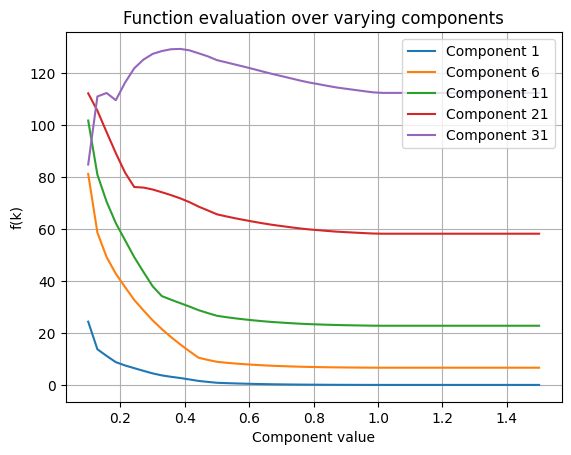

In [39]:
def graph_component_i(f, k_original, i_values, start, stop, num_points=100):
    """
    Function to graph the effect of changing specific components of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector.
    - i_values: A list of indices of the components to change (e.g., [1, 10, 20, 30, 40]).
    - start: The start value for the components.
    - stop: The stop value for the components.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the selected components of k change.
    """
    # Check if k_original has enough elements for the highest index in i_values
    if len(k_original) < np.max(i_values) + 1:
        raise ValueError("Input vector must be large enough to accommodate all indices in i_values.")

    # Generate a linspace for the components
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components not in i_values
    k_fixed = np.copy(k_original)
    
    # Plot results for each index in i_values
    for i in i_values:
        # Store the results of the function evaluations for this component
        results = []
        
        # Evaluate the function over the linspace
        for value in linspace_values:
            k_fixed[i] = value  # Update the i-th component
            result = f(k_fixed)[i]  # Evaluate the function (assumes f returns a vector)
            results.append(result)
        
        # Plot the results for this component
        plt.plot(linspace_values, results, label=f'Component {i+1}')
    
    # Customize the plot
    plt.title("Function evaluation over varying components")
    plt.xlabel("Component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.legend()
    plt.show()

graph_component_i(custom_function, k0, i_values=[30], start=0.1, stop=1.5, num_points=50)

In [ ]:
import numpy as np
from scipy.optimize import basinhopping

# Define your function f(x) (to be maximized)
def f(x):
    return -(x**2 - 4*x + 3)  # Example function (a downward-opening parabola)

# Define a wrapper to negate the function (to maximize)
def neg_f(x):
    return f(x[0])  # basinhopping requires a 1D array input

# Initial guess
x0 = np.array([0.5])  # Start in the middle of the interval [0, 1]

# Use basinhopping to find the maximum
result = basinhopping(neg_f, x0, niter=100, T=1.0, stepsize=0.1, 
                      minimizer_kwargs={"bounds": [(0, 1)]})

# Get the value of x that maximizes f
x_max = result.x[0]
max_value = -result.fun  # Negate the value since we minimized the negative

print("Value of x that maximizes f:", x_max)
print("Maximum value of f:", max_value)
